# Dask Features

- process data that doesn't fit into memory by breaking it into blocks and specifying task chains
- parallelize execution of tasks across cores and even nodes of a cluster
- move computation to the data rather than the other way around, to minimize communication overheads



In [1]:
import sys
import dask
import dask.multiprocessing

In [2]:
from time import sleep

def slowinc(x, delay=1):
    sleep(delay)
    return x + 1

def slowadd(x, y, delay=1):
    sleep(delay)
    return x + y

In [3]:
%%time
x = slowinc(1)
y = slowinc(2)
z = slowadd(x, y)

CPU times: user 850 µs, sys: 1.13 ms, total: 1.98 ms
Wall time: 3.01 s


# Parallelize with dask.delayed

- Functions wrapped by `dask.delayed` don't run immediately, but instead put those functions and arguments into a task graph. 
- The result is computed separately by calling the `.compute()` method.

In [4]:
from dask import delayed

In [5]:
x = delayed(slowinc)(1)
y = delayed(slowinc)(2)
z = delayed(slowadd)(x, y)

In [6]:
%%time
z.compute()

CPU times: user 7.03 ms, sys: 3.14 ms, total: 10.2 ms
Wall time: 2.01 s


5

# Dask graph

- Contains description of the calculations necessary to produce the result. 
- The z object is a lazy Delayed object. This object holds everything we need to compute the final result. We can compute the result with .compute() as above or we can visualize the task graph for this value with .visualize().

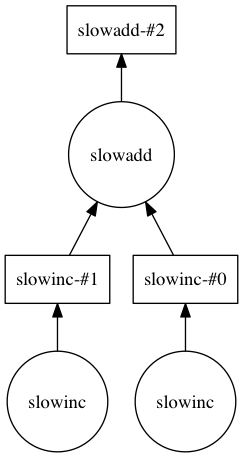

In [7]:
z.visualize()

# Parallelize a loop


In [8]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [9]:
%%time

results = []
for x in data:
    y = slowinc(x)
    results.append(y)
    
total = sum(results)

CPU times: user 8.97 ms, sys: 2.67 ms, total: 11.6 ms
Wall time: 8.03 s


### Exercise 5.1

- Parallelize this by appending the delayed `slowinc` calls to the list `results`.
- Display the graph of `total` computation
- Compute time elapsed for the computation.

In [10]:
results = []
for x in data:
    y = delayed(slowinc)(x)
    results.append(y)
    
total = (delayed)(sum)(results)

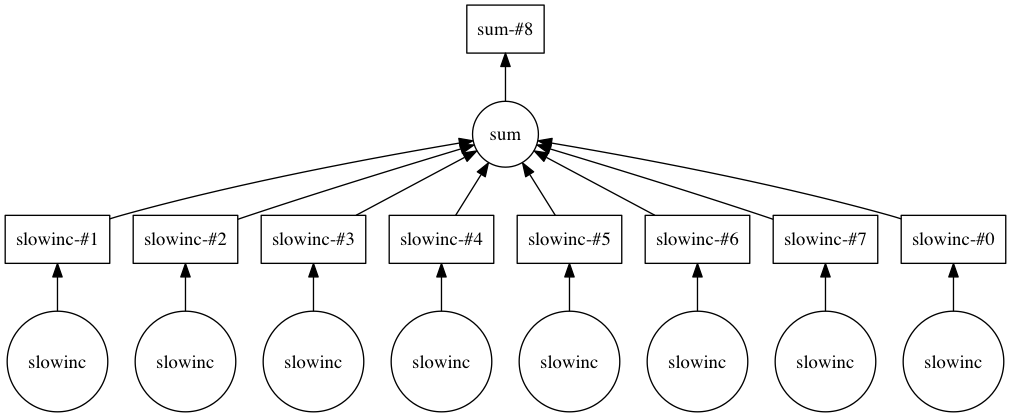

In [11]:
total.visualize()

In [12]:
%%time
total.compute()

CPU times: user 4.43 ms, sys: 2.2 ms, total: 6.63 ms
Wall time: 1.01 s


44

# Control flow
-  Delay only some functions, running a few of them immediately. This is helpful when those functions are fast and help us to determine what other slower functions we should call. 
- In the example below we iterate through a list of inputs. If that input is even then we want to call `half`. If the input is odd then we want to call `odd_process`. This iseven decision to call `half` or `odd_process` has to be made immediately (not lazily) in order for our graph-building Python code to proceed.


In [13]:
from random import randint

def half(x):
    sleep(1)
    return x // 2

def odd_process(x):
    sleep(1)
    return 3*x+1

def is_even(x):
    return not x % 2

data = [randint(0,100) for i in range(8)]
data

[10, 81, 5, 12, 5, 72, 40, 50]

In [14]:
%%time
results = []
for x in data:
    if is_even(x):
        y = half(x)
    else:
        y = odd_process(x)
    results.append(y)
    
total = sum(results)
print(total)

368
CPU times: user 9.1 ms, sys: 2.71 ms, total: 11.8 ms
Wall time: 8.03 s


### Exercise 5.2
- Parallelize the sequential code above using dask.delayed
- You will need to delay some functions, but not all
- Visualize and check the computed result


## Parallel Collections: Dask bag

Systems like Spark and Dask include "big data" collections with a small set of high-level primitives like map, filter, groupby, and join. With these common patterns we can often handle computations that are more complex than map, but are still structured.
In this section we repeat the submit example using the PySpark and the Dask.Bag APIs, which both provide parallel operations on linear collections of arbitrary objects.


## Spark/Dask.bag methods
We can construct most of the above computation with the following Spark/Dask.bag methods:
- *collection.map(function)*: apply function to each element in collection
- *collection.product(collection)*: Create new collection with every pair of inputs
- *collection.filter(predicate)*: Keep only elements of colleciton that match the predicate function
- *collection.max()*: Compute maximum element
We use these briefly in isolated exercises and then combine them to rewrite the previous computation from the submit section.

In [15]:
import dask.bag as db

seq = list(range(8))

b = db.from_sequence(seq)
b

dask.bag<from_se..., npartitions=8>

In [16]:
b.compute() 

[0, 1, 2, 3, 4, 5, 6, 7]

## map

In [17]:
%%time 
res = map(slowinc, seq) # apply slow inc on each element
print(*res)

1 2 3 4 5 6 7 8
CPU times: user 12 ms, sys: 6.38 ms, total: 18.4 ms
Wall time: 8.03 s


In [18]:
%time b.map(slowinc).compute()

CPU times: user 27.9 ms, sys: 30.6 ms, total: 58.5 ms
Wall time: 1.05 s


[1, 2, 3, 4, 5, 6, 7, 8]

In [19]:
b.filter(lambda x: x % 2 == 0).compute()

[0, 2, 4, 6]

In [20]:
# Cartesian product of each pair of elements in two sequences (or the same sequence in this case)

b.product(b).compute()

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (5, 6),
 (5, 7),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 6),
 (6, 7),
 (7, 0),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 7)]

In [21]:
# Chain operations to construct more complex computations

(b.map(lambda x: x ** 2)
  .product(b)
  .filter(lambda tup: tup[0] % 2 == 0)
  .compute())


[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (16, 0),
 (16, 1),
 (16, 2),
 (16, 3),
 (16, 4),
 (16, 5),
 (16, 6),
 (16, 7),
 (36, 0),
 (36, 1),
 (36, 2),
 (36, 3),
 (36, 4),
 (36, 5),
 (36, 6),
 (36, 7)]

### Exercise 5.3
- Parallelize the hdf5 conversion from json files
- Create a function `convert_to_hdf`
- Use dask.compute function on delayed calls of the funtion created list
- Is it really  faster as expected ?

In [22]:
import os  # library to get directory and file paths
import tarfile # this module makes possible to read and write tar archives

def extract_daily_stock():
    minutedir = os.path.join('../data', 'minute')
    if not os.path.exists(minutedir):
       print("Extracting daily stock data")
       tar_path = os.path.join('../data', 'daily_stock.tgz')
       with tarfile.open(tar_path, mode='r:gz') as minute:
          minute.extractall('../data/')
            
extract_daily_stock() #

In [23]:
%%time
import os, sys
from glob import glob
import pandas as pd
import json


here = os.getcwd() # get the current directory


stocks = ['hal', 'hp', 'hpq', 'ibm', 'jbl', 'jpm', 'luv', 'pcg','usb']


def convert_to_json(d):
    """ Convert all csv files of directory d into json format """
    filenames = sorted(glob(os.path.join(d, '*')))[-365:]
    outfn = d.replace('minute', 'json') + '.json'
    if os.path.exists(outfn):
        return
    with open(outfn, 'w') as f:
        for fn in filenames:
            df = pd.read_csv(fn)
            for rec in df.to_dict(orient='records'):
                json.dump(rec, f)
                f.write('\n')
    print("Finished JSON: %s" % d.split(os.path.sep)[-1])


js = os.path.join(here, '../data', 'json')
if not os.path.exists(js):
    os.mkdir(js)

for d in sorted(glob(os.path.join(here, '../data', 'minute', '*'))):
    convert_to_json(d)

CPU times: user 464 ms, sys: 96.1 ms, total: 560 ms
Wall time: 293 ms


In [24]:
import os, glob
filenames = sorted(glob.glob(os.path.join('../data', 'json', '*.json')))
filenames

['../data/json/hal.json',
 '../data/json/hp.json',
 '../data/json/hpq.json',
 '../data/json/ibm.json',
 '../data/json/jbl.json',
 '../data/json/jpm.json',
 '../data/json/luv.json',
 '../data/json/pcg.json',
 '../data/json/usb.json']

In [25]:
%%time

import json # or ujson
for fn in filenames:
    with open(fn) as f:
        data = [json.loads(line) for line in f]
        
    df = pd.DataFrame(data)
    
    out_filename = fn[:-5] + '.h5'
    df.to_hdf(out_filename, '/data')
    print("Finished : %s" % out_filename.split(os.path.sep)[-1])

Finished : hal.h5
Finished : hp.h5
Finished : hpq.h5
Finished : ibm.h5
Finished : jbl.h5
Finished : jpm.h5
Finished : luv.h5
Finished : pcg.h5
Finished : usb.h5
CPU times: user 12.6 s, sys: 979 ms, total: 13.6 s
Wall time: 13.5 s


In [26]:
from glob import glob
import os

filenames = sorted(glob(os.path.join('..', 'data', 'json', '*.h5')))  # ../data/json/*.json

In [27]:
%%time
series = {}
for fn in filenames:   # Simple map over filenames
    series[fn] = pd.read_hdf(fn)['close']

results = {}

for a in filenames:    # Doubly nested loop over the same collection
    for b in filenames:  
        if a != b:     # Filter out bad elements
            results[a, b] = series[a].corr(series[b])  # Apply function

((a, b), corr) = max(results.items(), key=lambda kv: kv[1])  # Reduction

print(corr)

0.9460009339480454
CPU times: user 631 ms, sys: 188 ms, total: 820 ms
Wall time: 818 ms


We use matplotlib to visually inspect the highly correlated timeseries

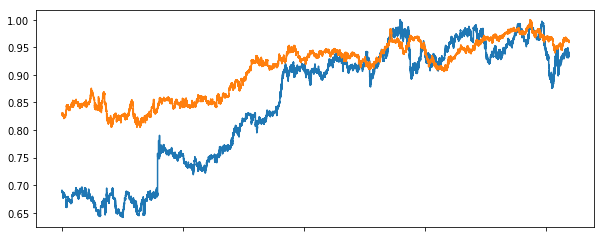

In [28]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(series[a]/series[a].max())
plt.plot(series[b]/series[b].max())
plt.xticks(visible=False);

In [29]:
%%time
### Parallel Code

import dask.bag as db

b = db.from_sequence(filenames)
series = b.map(lambda fn: pd.read_hdf(fn)['close'])

corr = (series.product(series)
              .filter(lambda ab: not (ab[0] == ab[1]).all())
              .map(lambda ab: ab[0].corr(ab[1])).max())

result = corr.compute()

CPU times: user 1.79 s, sys: 1.63 s, total: 3.42 s
Wall time: 5.85 s


In [30]:
result

0.9460009339480454

# References
* [Dask website](https://dask.pydata.org/)
